## Challenge "Predicting Lost Postal Shipments"

This competition comes from the All-Russian Championship, Russian Post track and asks us to detect parcels that eventually got lost.

We are given two large tabular files:

| File            | Rows | Purpose                            |
| --------------- | ---- | ---------------------------------- |
| **`train.csv`** | 6 M  | Labeled data (`label` = 1 ⇒ lost)  |
| **`test.csv`**  | 4 M  | Unlabeled |

A third file, **`sample_solution.csv`**, shows the required submission format.

#### Feature dictionary

| Column name                            | Meaning                                                                                                          |
| :------------------------------------- | :--------------------------------------------------------------------------------------------------------------- |
| **oper\_type**, **oper\_attr**         | Operation type and its attribute                                                                                 |
| **index\_oper**                        | Index (branch code) where the operation was performed                                                            |
| **type**                               | Code denoting the type of postal facility                                                                        |
| **priority**                           | Priority flag of the item                                                                                        |
| **is\_privatecategory**                | `Y` – branch of a closed-access category, `N` – otherwise                                                        |
| **class**                              | Postal object class / category                                                                                   |
| **is\_in\_yandex**                     | `Y` – branch address is displayed on Yandex.Maps, `N` – otherwise                                                |
| **is\_return**                         | `Y` – parcel is moving back to the sender, `N` – otherwise                                                       |
| **weight**                             | Weight in grams                                                                                                  |
| **mailtype**                           | Shipment type code                                                                                               |
| **mailctg**                            | Postal shipment category code                                                                                    |
| **mailrank**                           | Postal shipment rank code                                                                                        |
| **directctg**                          | Routing classification code                                                                                      |
| **transport\_pay**                     | Total shipping fee                                                                                               |
| **postmark**                           | Postal mark code                                                                                                 |
| **name\_mfi**                          | Declared contents as shown on the parcel tag                                                                     |
| **weight\_mfi**                        | Total weight of the declared contents                                                                            |
| **price\_mfi**                         | Total declared value of the contents                                                                             |
| **dist\_qty\_oper\_login\_1**          | Number of **unique operator logins** that handled this `mailtype` **at this branch index** and can be identified |
| **total\_qty\_oper\_login\_1**         | Number of **items** of this `mailtype` handled by identified operators at this branch index                      |
| **total\_qty\_oper\_login\_0**         | Number of **items** of this `mailtype` handled by **unknown** operators at this branch index                     |
| **total\_qty\_over\_index\_and\_type** | Total items of this `mailtype` processed at this branch index                                                    |
| **total\_qty\_over\_index**            | Total items processed at this branch index                                                                       |
| **is\_wrong\_sndr\_name**              | 1 – sender name clearly malformed, 0 – otherwise                                                                 |
| **is\_wrong\_rcpn\_name**              | 1 – recipient name clearly malformed, 0 – otherwise                                                              |
| **is\_wrong\_phone\_number**           | 1 – recipient phone clearly malformed, 0 – otherwise                                                             |
| **is\_wrong\_address**                 | 1 – recipient address clearly malformed, 0 – otherwise                                                           |
| **label** *(train only)*               | **Target**. 1 – tracking trail breaks here (parcel lost), 0 – parcel delivered or returned                       |


#### Evaluation metric

The leaderboard score is a weighted blend:


$ Score=0.1×Recall+0.9×ROC-AUC $

Hence we optimise primarily for AUC while keeping recall non-negligible.

## Import libraries

In [ ]:
# Core stack
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modelling
from catboost import CatBoost, CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# Utilities
from IPython.display import Markdown, display
import sklearn.metrics
import pickle

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 200)

## Data loading

In [ ]:
DATA_PATH = "train.csv"
df = pd.read_csv(DATA_PATH)

C:\Users\EGO\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


## Train / validation split

In [ ]:
RNG_SEED = 120922
SPLIT_IDX = 5_700_000   # first 5.7 M rows to train

df_shuffled = df.sample(frac=1, random_state=RNG_SEED)

df = df_shuffled.iloc[:SPLIT_IDX].copy()
df_test = df_shuffled.iloc[SPLIT_IDX:].copy()

#### Save the test set

In [9]:
# df_test.to_csv("test_my.csv", sep = ',', line_terminator='\n', index = False)

## Data overview

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5700000 entries, 3540324 to 5777925
Data columns (total 29 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   id                             int64  
 1   oper_type + oper_attr          object 
 2   index_oper                     object 
 3   type                           object 
 4   priority                       float64
 5   is_privatecategory             object 
 6   class                          float64
 7   is_in_yandex                   object 
 8   is_return                      object 
 9   weight                         float64
 10  mailtype                       float64
 11  mailctg                        float64
 12  mailrank                       float64
 13  directctg                      float64
 14  transport_pay                  float64
 15  postmark                       float64
 16  name_mfi                       object 
 17  weight_mfi                     float64
 

### Column grouping

In [ ]:
num_cols = [
    'weight',
    'transport_pay',
    'weight_mfi',
    'price_mfi',
    'dist_qty_oper_login_1',
    'total_qty_oper_login_1',
    'total_qty_oper_login_0',
    'total_qty_over_index_and_type',
    'total_qty_over_index'
]


cat_cols = [
    'type',
    'is_privatecategory', 
    'class', 
    'is_in_yandex', 
     'priority', 
    'mailctg', 
    'directctg', 
    'mailtype', 
    'is_return'
]

# Columns dropped after hypothesis testing / feature analysis
del_col = [
    'oper_type + oper_attr',
    'id',
    'name_mfi',
    'mailrank',
    'index_oper',
    'type',
    'is_privatecategory', 
    'class', 
    'is_in_yandex', 
     'priority', 
    'postmark',
    'mailctg', 
    'directctg', 
    'mailtype', 
    'is_return',
    'is_wrong_sndr_name',
    'is_wrong_rcpn_name',
    'is_wrong_phone_number',
    'is_wrong_address'
]

In [12]:
df.head(3)

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,mailtype,mailctg,mailrank,directctg,transport_pay,postmark,name_mfi,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label
3540324,7960122,1042_-1,102971.0,Цех,7506.0,N,0.0,N,N,81.0,5.0,0.0,0.0,2.0,0.00,0.0,women bra set,80.0,150.0,181.0,76138189.0,8747.0,76146936.0,84110459.0,0,1,1,0,0
4836618,103379,1001_-1,620962,Цех,7503.0,N,0.0,Y,N,74.0,5.0,1.0,0.0,2.0,19.44,0.0,0,0.0,0.0,62.0,3246292.0,3233068.0,6479360.0,52708071.0,0,0,0,0,0
123964,4625182,8_6,102976.0,ММПО,7503.0,N,0.0,N,N,1327.0,5.0,1.0,0.0,2.0,0.00,0.0,"Grinding head,Teeth Whitening,bike Shifter",817.0,8328.0,914.0,48856658.0,83318932.0,132175590.0,136819803.0,0,0,0,0,0


---------------------------------------------------------

In [ ]:
for col in df.columns:
    print(col)
    print(df[col].value_counts())
    print("-" * 29)

id
7960122    1
2560659    1
1371300    1
400256     1
9165383    1
          ..
5406018    1
1203363    1
6732530    1
4656975    1
8297396    1
Name: id, Length: 5700000, dtype: int64
-----------------------------
oper_type + oper_attr
1020_-1      658262
1022_-1      623848
1019_-1      393084
8_0          382815
1_-1         341290
1001_-1      335453
1018_-1      302106
1004_-1      294070
1042_-1      278747
1041_-1      275448
1023_-1      204305
8_2          135768
1043_-1      132547
8_6          128230
1044_-1      127322
2_1          112627
8_3          108876
1014_-1       99986
1016_-1       70748
11_-1         70438
9_-1          67437
8_13          66103
0_-1          65949
185_-1        55162
183_-1        54819
184_-1        54810
14_1          54775
39_-1         54737
29_-1         39457
2_6           21935
1026_-1       20490
14_10          9319
8_5            8191
131_-1         6198
12_1           5168
1027_-1        4381
26_-1          3963
1025_-1        3237
8_

136819803.0    756153
188407812.0    317351
72981134.0     313128
164927295.0    259241
84110459.0     151445
                ...  
157243.0            1
9367.0              1
5090.0              1
19880.0             1
1157.0              1
Name: total_qty_over_index, Length: 35078, dtype: int64
-----------------------------
is_wrong_sndr_name
0    5685331
1      14669
Name: is_wrong_sndr_name, dtype: int64
-----------------------------
is_wrong_rcpn_name
0    4218927
1    1481073
Name: is_wrong_rcpn_name, dtype: int64
-----------------------------
is_wrong_phone_number
0    4725475
1     974525
Name: is_wrong_phone_number, dtype: int64
-----------------------------
is_wrong_address
0    5692769
1       7231
Name: is_wrong_address, dtype: int64
-----------------------------
label
0    5537657
1     162343
Name: label, dtype: int64
-----------------------------


In [ ]:
# Explore lost-parcel count for every feature
for col in df.columns:
    if col == "label":
        continue
    try:
        pivot = df.pivot_table(values="label", index=col, aggfunc="sum")
        print(pivot)
    except Exception:
        print("Just label")

         label
id            
1            0
4            0
6            0
7            0
8            0
...        ...
9999991      0
9999992      0
9999995      0
9999996      0
9999999      0

[5700000 rows x 1 columns]
                        label
oper_type + oper_attr        
0_-1                        0
1001_-1                     0
1002_-1                     0
1003_-1                     0
1004_-1                105882
1005_-1                     0
1009_-1                     0
1012_-1                     0
1013_-1                     0
1014_-1                     0
1015_-1                     0
1016_-1                     0
1017_-1                     0
1017_1000                   0
1017_1001                   0
1018_-1                     0
1019_-1                     0
1020_-1                   330
1021_-1                     0
1022_-1                     0
1023_-1                     0
1025_-1                     0
1026_-1                     0
1027_-1                    

                        label
total_qty_oper_login_1       
0.0                       609
1.0                        19
2.0                        17
3.0                         8
4.0                         3
...                       ...
88855538.0                  0
89268735.0                  0
133558721.0                 0
137058462.0                 0
141688843.0                 0

[18365 rows x 1 columns]
                        label
total_qty_oper_login_0       
0.0                        19
1.0                         3
2.0                        10
3.0                         2
4.0                         2
...                       ...
91123247.0              25326
96079047.0               5105
116432632.0             24138
337771067.0                11
415658138.0                 0

[9346 rows x 1 columns]
                               label
total_qty_over_index_and_type       
0.0                               19
1.0                                0
2.0                  

**Findings**

* `id`, `mailrank`, `postmark` & `name_mfi` add little predictive power.  
* `oper_type + oper_attr` is highly imbalanced: 105 882 of 160 000 lost items sit in category `1004_-1`; keeping it would over-weight that group.  
* `index_oper` needs normalisation (mixed formats / missing codes).  
* Other features are likely useful.  
* Missing codes (`0`, blanks) are left untouched—could be legitimate internal values.  
* Same for zero `weight`: real parcels sometimes weigh “0 g” in Russian Post manifests.

### Null / zero check for `index_oper`

In [ ]:
df[df["index_oper"] == "0"].count()

id                               1339
oper_type + oper_attr            1339
index_oper                       1339
type                             1339
priority                         1339
is_privatecategory               1339
class                            1339
is_in_yandex                     1339
is_return                        1339
weight                           1339
mailtype                         1339
mailctg                          1339
mailrank                         1339
directctg                        1339
transport_pay                    1339
postmark                         1339
name_mfi                         1339
weight_mfi                       1339
price_mfi                        1339
dist_qty_oper_login_1            1339
total_qty_oper_login_1           1339
total_qty_oper_login_0           1339
total_qty_over_index_and_type    1339
total_qty_over_index             1339
is_wrong_sndr_name               1339
is_wrong_rcpn_name               1339
is_wrong_pho

### Class imbalance

In [ ]:
df["label"].value_counts()

0    5537657
1     162343
Name: label, dtype: int64

### Encode categoricals as loss rate per category (`percent_of_*`)

In [ ]:
def loss_rate(row, col, lost_per_cat, total_per_cat):
    cat = row[col]
    return (lost_per_cat.get(cat, 0) * 100) / total_per_cat.get(cat, 1)

In [ ]:
columns_all = ['type', 'priority', 'is_privatecategory', 'class', 'is_in_yandex', 'is_return',
              'mailtype', 'mailctg', 'directctg', 'is_wrong_sndr_name', 'is_wrong_rcpn_name', 'is_wrong_phone_number',
              'is_wrong_address']

In [ ]:
for col in cat_cols:
    total_per_cat = df[col].value_counts().to_dict()
    lost_per_cat  = (
        df[df["label"] == 1][col].value_counts().to_dict()
    )
    df[f"%_of_{col}"] = df.apply(
        loss_rate, axis=1, col=col,
        lost_per_cat=lost_per_cat,
        total_per_cat=total_per_cat,
    )


C:\Users\EGO\AppData\Local\Temp/ipykernel_14888/2908989807.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['%_of_'+ i] = df.apply(percent_of,column = i, pivot = pivot_type, values = types, axis = 1)


In [20]:
df.head()

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,mailtype,mailctg,mailrank,directctg,transport_pay,postmark,name_mfi,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label,%_of_type,%_of_priority,%_of_is_privatecategory,%_of_class,%_of_is_in_yandex,%_of_is_return,%_of_mailtype,%_of_mailctg,%_of_directctg,%_of_is_wrong_sndr_name,%_of_is_wrong_rcpn_name,%_of_is_wrong_phone_number,%_of_is_wrong_address
3540324,7960122,1042_-1,102971.0,Цех,7506.0,N,0.0,N,N,81.0,5.0,0.0,0.0,2.0,0.00,0.0,women bra set,80.0,150.0,181.0,76138189.0,8747.0,76146936.0,84110459.0,0,1,1,0,0,0.096186,0.422051,2.845951,2.162049,3.190877,2.848811,2.850904,8.193363,2.855003,2.831286,2.466658,7.791488,2.835738
4836618,103379,1001_-1,620962,Цех,7503.0,N,0.0,Y,N,74.0,5.0,1.0,0.0,2.0,19.44,0.0,0,0.0,0.0,62.0,3246292.0,3233068.0,6479360.0,52708071.0,0,0,0,0,0,0.096186,3.701305,2.845951,2.162049,2.341582,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738
123964,4625182,8_6,102976.0,ММПО,7503.0,N,0.0,N,N,1327.0,5.0,1.0,0.0,2.0,0.00,0.0,"Grinding head,Teeth Whitening,bike Shifter",817.0,8328.0,914.0,48856658.0,83318932.0,132175590.0,136819803.0,0,0,0,0,0,6.767832,3.701305,2.845951,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738
3490911,2683876,1020_-1,628204,Участок,7503.0,N,0.0,Y,N,565.0,5.0,1.0,0.0,2.0,0.00,0.0,"Memo Pad,Bluetooth keyboard,Cartoon Badge,band...",520.0,2401.0,9.0,138819.0,14098.0,152917.0,1131096.0,0,0,0,0,0,0.097536,3.701305,2.845951,2.162049,2.341582,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738
2109802,2185397,1042_-1,102971.0,Цех,7506.0,N,0.0,N,N,168.0,5.0,1.0,0.0,2.0,23.97,0.0,Massage Stick,113.0,160.0,186.0,60613352.0,10648.0,60624000.0,75592387.0,0,0,0,0,0,0.096186,0.422051,2.845951,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738


## Clean `index_oper`

In [ ]:
df = df[~df["index_oper"].isin([" ", "0"])]
df[df["index_oper"] == "0"].count()   # sanity check - all zeros gone

id                               0
oper_type + oper_attr            0
index_oper                       0
type                             0
priority                         0
is_privatecategory               0
class                            0
is_in_yandex                     0
is_return                        0
weight                           0
mailtype                         0
mailctg                          0
mailrank                         0
directctg                        0
transport_pay                    0
postmark                         0
name_mfi                         0
weight_mfi                       0
price_mfi                        0
dist_qty_oper_login_1            0
total_qty_oper_login_1           0
total_qty_oper_login_0           0
total_qty_over_index_and_type    0
total_qty_over_index             0
is_wrong_sndr_name               0
is_wrong_rcpn_name               0
is_wrong_phone_number            0
is_wrong_address                 0
label               

### Normilize `index_oper`

In [ ]:
df["index_oper"] = (
    df["index_oper"].astype(float).astype(int).astype(str)
)
df.head()

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,mailtype,mailctg,mailrank,directctg,transport_pay,postmark,name_mfi,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label,%_of_type,%_of_priority,%_of_is_privatecategory,%_of_class,%_of_is_in_yandex,%_of_is_return,%_of_mailtype,%_of_mailctg,%_of_directctg,%_of_is_wrong_sndr_name,%_of_is_wrong_rcpn_name,%_of_is_wrong_phone_number,%_of_is_wrong_address
3540324,7960122,1042_-1,102971,Цех,7506.0,N,0.0,N,N,81.0,5.0,0.0,0.0,2.0,0.00,0.0,women bra set,80.0,150.0,181.0,76138189.0,8747.0,76146936.0,84110459.0,0,1,1,0,0,0.096186,0.422051,2.845951,2.162049,3.190877,2.848811,2.850904,8.193363,2.855003,2.831286,2.466658,7.791488,2.835738
4836618,103379,1001_-1,620962,Цех,7503.0,N,0.0,Y,N,74.0,5.0,1.0,0.0,2.0,19.44,0.0,0,0.0,0.0,62.0,3246292.0,3233068.0,6479360.0,52708071.0,0,0,0,0,0,0.096186,3.701305,2.845951,2.162049,2.341582,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738
123964,4625182,8_6,102976,ММПО,7503.0,N,0.0,N,N,1327.0,5.0,1.0,0.0,2.0,0.00,0.0,"Grinding head,Teeth Whitening,bike Shifter",817.0,8328.0,914.0,48856658.0,83318932.0,132175590.0,136819803.0,0,0,0,0,0,6.767832,3.701305,2.845951,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738
3490911,2683876,1020_-1,628204,Участок,7503.0,N,0.0,Y,N,565.0,5.0,1.0,0.0,2.0,0.00,0.0,"Memo Pad,Bluetooth keyboard,Cartoon Badge,band...",520.0,2401.0,9.0,138819.0,14098.0,152917.0,1131096.0,0,0,0,0,0,0.097536,3.701305,2.845951,2.162049,2.341582,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738
2109802,2185397,1042_-1,102971,Цех,7506.0,N,0.0,N,N,168.0,5.0,1.0,0.0,2.0,23.97,0.0,Massage Stick,113.0,160.0,186.0,60613352.0,10648.0,60624000.0,75592387.0,0,0,0,0,0,0.096186,0.422051,2.845951,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738


### Cast remaining categorical columns to `str`

In [ ]:
for col in cat_cols:
    df[col] = df[col].astype(str)

df = df[df["index_oper"] != "0"] # extra safety filter
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5697555 entries, 3540324 to 5777925
Data columns (total 42 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   id                             int64  
 1   oper_type + oper_attr          object 
 2   index_oper                     object 
 3   type                           object 
 4   priority                       object 
 5   is_privatecategory             object 
 6   class                          object 
 7   is_in_yandex                   object 
 8   is_return                      object 
 9   weight                         float64
 10  mailtype                       object 
 11  mailctg                        object 
 12  mailrank                       float64
 13  directctg                      object 
 14  transport_pay                  float64
 15  postmark                       float64
 16  name_mfi                       object 
 17  weight_mfi                     float64
 

### City-level feature engineering

#### Region mapping
Very few indices resolve cleanly via `pgeocode`, so we rely on the rule: **first three digits identify the region** (publicly available table).

In [5]:
my_dict = {
 385:'Республика Адыгея',
 649:'Республика Алтай',
 656:'Алтайский край',
 657:'Алтайский край',
 658:'Алтайский край',
 659:'Алтайский край',
 675:'Амурская область',
 676:'Амурская область',
 163:'Архангельская область',
 164:'Архангельская область',
 165:'Архангельская область',
 414:'Астраханская область',
 415:'Астраханская область',
 416:'Астраханская область',
 450:'Республика Башкортостан',
 451:'Республика Башкортостан',
 452:'Республика Башкортостан',
 453:'Республика Башкортостан',
 308:'Белгородская область',
 309:'Белгородская область',
 241:'Брянская область',
 242:'Брянская область',
 243:'Брянская область',
 670:'Республика Бурятия',
 671:'Республика Бурятия',
 600:'Владимирская область',
 601:'Владимирская область',
 602:'Владимирская область',
 400:'Волгоградская область',
 401:'Волгоградская область',
 402:'Волгоградская область',
 403:'Волгоградская область',
 404:'Волгоградская область',
 160:'Вологодская область',
 161:'Вологодская область',
 162:'Вологодская область',
 394:'Воронежская область',
 395:'Воронежская область',
 396:'Воронежская область',
 397:'Воронежская область',
 367:'Республика Дагестан',
 368:'Республика Дагестан',
 679:'Еврейская авт. область',
 672:'Забайкальский край',
 673:'Забайкальский край',
 674:'Забайкальский край',
 687:'Агинский Бурятский округ',
 153:'Ивановская область',
 154:'Ивановская область',
 155:'Ивановская область',
 386:'Республика Ингушетия',
 664:'Иркутская область',
 665:'Иркутская область',
 666:'Иркутская область',
 669:'Усть-Ордынский Бурятский округ',
 360:'Кабардино-Балкарская Республика',
 361:'Кабардино-Балкарская Республика',
 236:'Калининградская область',
 237:'Калининградская область',
 238:'Калининградская область',
 358:'Республика Калмыкия',
 359:'Республика Калмыкия',
 248:'Калужская область',
 249:'Калужская область',
 683:'Камчатский край',
 684:'Камчатский край',
 688:'Корякский автономный округ',
 369:'Карачаево-Черкесская Республика',
 185:'Республика Карелия',
 186:'Республика Карелия',
 650:'Кемеровская область',
 651:'Кемеровская область',
 652:'Кемеровская область',
 653:'Кемеровская область',
 654:'Кемеровская область',
 610:'Кировская область',
 611:'Кировская область',
 612:'Кировская область',
 613:'Кировская область',
 167:'Республика Коми',
 168:'Республика Коми',
 169:'Республика Коми',
 156:'Костромская область',
 157:'Костромская область',
 350:'Краснодарский край',
 351:'Краснодарский край',
 352:'Краснодарский край',
 353:'Краснодарский край',
 354:'Краснодарский край',
 660:'Красноярский край',
 661:'Красноярский край',
 662:'Красноярский край',
 663:'Красноярский край',
 647:'Таймырский Долгано-Ненецкий район',
 648:'Эвенкийский район',
 295:'Республика Крым',
 296:'Республика Крым',
 297:'Республика Крым',
 298:'Республика Крым',
 640:'Курганская область',
 641:'Курганская область',
 305:'Курская область',
 306:'Курская область',
 307:'Курская область',
 187:'Ленинградская область',
 188:'Ленинградская область',
 398:'Липецкая область',
 399:'Липецкая область',
 685:'Магаданская область',
 686:'Магаданская область',
 424:'Республика Марий Эл',
 425:'Республика Марий Эл',
 430:'Республика Мордовия',
 431:'Республика Мордовия',
 101:'Москва',
 102:'Москва',
 103:'Москва',
 104:'Москва',
 105:'Москва',
 106:'Москва',
 107:'Москва',
 108:'Москва',
 109:'Москва',
 110:'Москва',
 111:'Москва',
 112:'Москва',
 113:'Москва',
 114:'Москва',
 115:'Москва',
 116:'Москва',
 117:'Москва',
 118:'Москва',
 119:'Москва',
 120:'Москва',
 121:'Москва',
 122:'Москва',
 123:'Москва',
 124:'Москва',
 125:'Москва',
 126:'Москва',
 127:'Москва',
 128:'Москва',
 129:'Москва',
 130:'Москва',
 131:'Москва',
 132:'Москва',
 133:'Москва',
 134:'Москва',
 135:'Москва',
 140:'Московская область',
 141:'Московская область',
 142:'Московская область',
 143:'Московская область',
 144:'Московская область',
 183:'Мурманская область',
 184:'Мурманская область',
 166:'Ненецкий автономный округ',
 603:'Нижегородская область',
 604:'Нижегородская область',
 605:'Нижегородская область',
 606:'Нижегородская область',
 607:'Нижегородская область',
 173:'Новгородская область',
 174:'Новгородская область',
 175:'Новгородская область',
 630:'Новосибирская область',
 631:'Новосибирская область',
 632:'Новосибирская область',
 633:'Новосибирская область',
 644:'Омская область',
 645:'Омская область',
 646:'Омская область',
 460:'Оренбургская область',
 461:'Оренбургская область',
 462:'Оренбургская область',
 302:'Орловская область',
 303:'Орловская область',
 440:'Пензенская область',
 441:'Пензенская область',
 442:'Пензенская область',
 614:'Пермский край',
 615:'Пермский край',
 616:'Пермский край',
 617:'Пермский край',
 618:'Пермский край',
 619:'Коми-Пермяцкий округ',
 690:'Приморский край',
 691:'Приморский край',
 692:'Приморский край',
 180:'Псковская область',
 181:'Псковская область',
 182:'Псковская область',
 344:'Ростовская область',
 345:'Ростовская область',
 346:'Ростовская область',
 347:'Ростовская область',
 390:'Рязанская область',
 391:'Рязанская область',
 443:'Самарская область',
 444:'Самарская область',
 445:'Самарская область',
 446:'Самарская область',
 190:'Санкт-Петербург',
 191:'Санкт-Петербург',
 192:'Санкт-Петербург',
 193:'Санкт-Петербург',
 194:'Санкт-Петербург',
 195:'Санкт-Петербург',
 196:'Санкт-Петербург',
 197:'Санкт-Петербург',
 198:'Санкт-Петербург',
 199:'Санкт-Петербург',
 410:'Саратовская область',
 411:'Саратовская область',
 412:'Саратовская область',
 413:'Саратовская область',
 677:'Республика Саха (Якутия)',
 678:'Республика Саха (Якутия)',
 693:'Сахалинская область',
 694:'Сахалинская область',
 620:'Свердловская область',
 621:'Свердловская область',
 622:'Свердловская область',
 623:'Свердловская область',
 624:'Свердловская область',
 299:'Севастополь',
 362:'Северная Осетия',
 363:'Северная Осетия',
 214:'Смоленская область',
 215:'Смоленская область',
 216:'Смоленская область',
 355:'Ставропольский край',
 356:'Ставропольский край',
 357:'Ставропольский край',
 392:'Тамбовская область',
 393:'Тамбовская область',
 420:'Республика Татарстан',
 421:'Республика Татарстан',
 422:'Республика Татарстан',
 423:'Республика Татарстан',
 170:'Тверская область',
 171:'Тверская область',
 172:'Тверская область',
 634:'Томская область',
 635:'Томская область',
 636:'Томская область',
 300:'Тульская область',
 301:'Тульская область',
 667:'Республика Тыва (Тува)',
 668:'Республика Тыва (Тува)',
 625:'Тюменская область',
 626:'Тюменская область',
 627:'Тюменская область',
 426:'Удмуртская Республика',
 427:'Удмуртская Республика',
 432:'Ульяновская область',
 433:'Ульяновская область',
 680:'Хабаровский край',
 681:'Хабаровский край',
 682:'Хабаровский край',
 655:'Республика Хакасия',
 628:'Ханты-Мансийский автономный округ',
 454:'Челябинская область',
 455:'Челябинская область',
 456:'Челябинская область',
 457:'Челябинская область',
 364:'Чеченская Республика',
 365:'Чеченская Республика',
 366:'Чеченская Республика',
 428:'Чувашская Республика',
 429:'Чувашская Республика',
 689:'Чукотский автономный округ',
 629:'Ямало-Ненецкий автономный округ',
 150:'Ярославская область',
 151:'Ярославская область',
 152:'Ярославская область',
 800:'Дополнительные почтовые отделения'}

#### Helper

In [ ]:
def map_region(row, lookup):
    prefix = int(row["index_oper"][:3])
    return lookup.get(prefix, "unknown")

df["zip_city"] = df.apply(map_region, axis=1, lookup=my_dict)
df.head(10)

,id,oper_type + oper_attr,index_oper,type,priority,is_privatecategory,class,is_in_yandex,is_return,weight,mailtype,mailctg,mailrank,directctg,transport_pay,postmark,name_mfi,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,is_wrong_sndr_name,is_wrong_rcpn_name,is_wrong_phone_number,is_wrong_address,label,%_of_type,%_of_priority,%_of_is_privatecategory,%_of_class,%_of_is_in_yandex,%_of_is_return,%_of_mailtype,%_of_mailctg,%_of_directctg,%_of_is_wrong_sndr_name,%_of_is_wrong_rcpn_name,%_of_is_wrong_phone_number,%_of_is_wrong_address,zip_city
3540324,7960122,1042_-1,102971,Цех,7506.0,N,0.0,N,N,81.0,5.0,0.0,0.0,2.0,0.00,0.0,women bra set,80.0,150.0,181.0,76138189.0,8747.0,76146936.0,84110459.0,0,1,1,0,0,0.096186,0.422051,2.845951,2.162049,3.190877,2.848811,2.850904,8.193363,2.855003,2.831286,2.466658,7.791488,2.835738,Москва
4836618,103379,1001_-1,620962,Цех,7503.0,N,0.0,Y,N,74.0,5.0,1.0,0.0,2.0,19.44,0.0,0,0.0,0.0,62.0,3246292.0,3233068.0,6479360.0,52708071.0,0,0,0,0,0,0.096186,3.701305,2.845951,2.162049,2.341582,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,Свердловская область
123964,4625182,8_6,102976,ММПО,7503.0,N,0.0,N,N,1327.0,5.0,1.0,0.0,2.0,0.00,0.0,"Grinding head,Teeth Whitening,bike Shifter",817.0,8328.0,914.0,48856658.0,83318932.0,132175590.0,136819803.0,0,0,0,0,0,6.767832,3.701305,2.845951,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,Москва
3490911,2683876,1020_-1,628204,Участок,7503.0,N,0.0,Y,N,565.0,5.0,1.0,0.0,2.0,0.00,0.0,"Memo Pad,Bluetooth keyboard,Cartoon Badge,band...",520.0,2401.0,9.0,138819.0,14098.0,152917.0,1131096.0,0,0,0,0,0,0.097536,3.701305,2.845951,2.162049,2.341582,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,Ханты-Мансийский автономный округ
2109802,2185397,1042_-1,102971,Цех,7506.0,N,0.0,N,N,168.0,5.0,1.0,0.0,2.0,23.97,0.0,Massage Stick,113.0,160.0,186.0,60613352.0,10648.0,60624000.0,75592387.0,0,0,0,0,0,0.096186,0.422051,2.845951,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,Москва
1344659,2088636,29_-1,630875,ТИ,7506.0,N,0.0,Y,N,51.0,5.0,0.0,0.0,2.0,0.00,0.0,Phone Bumpers,51.0,177.0,1.0,34807.0,201357.0,236164.0,236272.0,0,1,0,0,0,0.000000,0.422051,2.845951,2.162049,2.341582,2.848811,2.850904,8.193363,2.855003,2.831286,2.466658,1.828663,2.835738,Новосибирская область
1373397,1502240,8_0,200984,ТИ,7503.0,N,0.0,Y,N,20.0,5.0,1.0,0.0,2.0,0.00,0.0,"Ear Studs,Bracelet",25.0,150.0,1.0,1192807.0,1192807.0,2385614.0,2666568.0,0,0,0,0,0,0.000000,3.701305,2.845951,2.162049,2.341582,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,unknown
190170,4341853,1022_-1,367962,Цех,7504.0,N,0.0,Y,N,33.0,5.0,1.0,0.0,2.0,0.00,0.0,Oil Pump Worm,26.0,100.0,31.0,1384588.0,3401.0,1387989.0,10402044.0,0,1,0,0,0,0.096186,6.051960,2.845951,2.162049,2.341582,2.848811,2.850904,1.423156,2.855003,2.831286,2.466658,1.828663,2.835738,Республика Дагестан
3718053,8879971,1019_-1,125373,ГОПС,7503.0,N,3.0,Y,N,1897.0,5.0,1.0,0.0,2.0,103.62,0.0,Bathroom Shelves,1707.0,1200.0,25.0,46766.0,9135.0,55901.0,808096.0,0,0,0,0,0,10.529771,3.701305,2.845951,9.175427,2.341582,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,Москва
2634488,8902702,1022_-1,102971,Цех,7506.0,N,0.0,N,N,36.0,5.0,1.0,0.0,2.0,0.00,0.0,car sticker,32.0,500.0,184.0,67541214.0,7870.0,67549084.0,72981134.0,0,0,0,0,0,0.096186,0.422051,2.845951,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,Москва


In [36]:
df = df.fillna('unknown')

#### Loss-rate per region

In [ ]:
city_counts = df["zip_city"].value_counts().to_dict()
city_losses = df.pivot_table(values="label", index="zip_city", aggfunc="sum").to_dict()

df["%_of_zip_city"] = df.apply(
    loss_rate,
    axis=1,
    col="zip_city",
    lost_per_cat=city_losses["label"],
    total_per_cat=city_counts,
)

pd.pivot_table(df, values="%_of_zip_city", index="zip_city", aggfunc="mean")

,%_of_zip_city
zip_city,
unknown,0.000000
Агинский Бурятский округ,4.347826
Алтайский край,5.332159
Амурская область,2.701790
Архангельская область,1.632571
Астраханская область,5.372829
Белгородская область,3.543521
Брянская область,1.245854
Владимирская область,2.338151


Save a copy before dropping columns (needed for test-set processing).

In [ ]:
df_copy = df.copy()
for c in cat_cols:
    df_copy[c] = df_copy[c].astype(str)

### Drop unused features

In [ ]:
df.drop(del_col + ["zip_city"], axis=1, inplace=True)

### New numeric features

In [ ]:
# Share of this mailtype at the branch
df["%_index_and_type"] = (
    df["total_qty_over_index_and_type"] * 100 / df["total_qty_over_index"]
)

# Share handled by unknown operators
df["%_unknown"] = (
    df["total_qty_oper_login_0"] * 100 / df["total_qty_over_index_and_type"]
)

# Parcels per identified operator
df["order_per_account"] = (
    df["total_qty_over_index_and_type"] / df["dist_qty_oper_login_1"]
)

### Balance the classes via oversampling

In [ ]:
df_0 = df[df["label"] == 0]
df_1 = df[df["label"] == 1]

oversampled_df = df_1.copy()
for _ in range(28): # empirically chosen multiplier
    sample = df_1.sample(150_000, random_state=RNG_SEED)
    oversampled_df = pd.concat([oversampled_df, sample], axis=0)

oversampled_df.count()

weight                           4362343
transport_pay                    4362343
weight_mfi                       4362343
price_mfi                        4362343
dist_qty_oper_login_1            4362343
total_qty_oper_login_1           4362343
total_qty_oper_login_0           4362343
total_qty_over_index_and_type    4362343
total_qty_over_index             4362343
label                            4362343
%_of_type                        4362343
%_of_priority                    4362343
%_of_is_privatecategory          4362343
%_of_class                       4362343
%_of_is_in_yandex                4362343
%_of_is_return                   4362343
%_of_mailtype                    4362343
%_of_mailctg                     4362343
%_of_directctg                   4362343
%_of_is_wrong_sndr_name          4362343
%_of_is_wrong_rcpn_name          4362343
%_of_is_wrong_phone_number       4362343
%_of_is_wrong_address            4362343
%_of_zip_city                    4362343
%_index_and_type

In [ ]:
df = pd.concat([oversampled_df, df_0], axis=0)
df.count()

weight                           9897555
transport_pay                    9897555
weight_mfi                       9897555
price_mfi                        9897555
dist_qty_oper_login_1            9897555
total_qty_oper_login_1           9897555
total_qty_oper_login_0           9897555
total_qty_over_index_and_type    9897555
total_qty_over_index             9897555
label                            9897555
%_of_type                        9897555
%_of_priority                    9897555
%_of_is_privatecategory          9897555
%_of_class                       9897555
%_of_is_in_yandex                9897555
%_of_is_return                   9897555
%_of_mailtype                    9897555
%_of_mailctg                     9897555
%_of_directctg                   9897555
%_of_is_wrong_sndr_name          9897555
%_of_is_wrong_rcpn_name          9897555
%_of_is_wrong_phone_number       9897555
%_of_is_wrong_address            9897555
%_of_zip_city                    9897555
%_index_and_type

In [ ]:
df = df.dropna()
df.isna().sum()

weight                           0
transport_pay                    0
weight_mfi                       0
price_mfi                        0
dist_qty_oper_login_1            0
total_qty_oper_login_1           0
total_qty_oper_login_0           0
total_qty_over_index_and_type    0
total_qty_over_index             0
label                            0
%_of_type                        0
%_of_priority                    0
%_of_is_privatecategory          0
%_of_class                       0
%_of_is_in_yandex                0
%_of_is_return                   0
%_of_mailtype                    0
%_of_mailctg                     0
%_of_directctg                   0
%_of_is_wrong_sndr_name          0
%_of_is_wrong_rcpn_name          0
%_of_is_wrong_phone_number       0
%_of_is_wrong_address            0
%_of_zip_city                    0
%_index_and_type                 0
%_unknown                        0
order_per_account                0
dtype: int64

In [ ]:
df = df.sample(len(df), random_state=RNG_SEED)

In [26]:
df

,weight,transport_pay,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,label,...,%_of_mailctg,%_of_directctg,%_of_is_wrong_sndr_name,%_of_is_wrong_rcpn_name,%_of_is_wrong_phone_number,%_of_is_wrong_address,%_of_zip_city,%_index_and_type,%_unknown,order_per_account
117037,1989.0,128.05,0.0,0.0,186.0,60613352.0,10648.0,60624000.0,75592387.0,0,...,1.423156,2.855003,2.831286,2.466658,1.828663,2.835738,3.498459,80.198552,0.017564,325935.483871
1283098,49.0,0.00,50.0,3.0,914.0,48856658.0,83318932.0,132175590.0,136819803.0,1,...,8.193363,2.855003,2.831286,2.466658,7.791488,2.835738,3.498459,96.605599,63.036550,144612.242888
3344511,27.0,0.00,25.0,180.0,315.0,6900306.0,1421787.0,8322093.0,13893124.0,0,...,1.423156,2.855003,2.831286,2.466658,1.828663,2.835738,0.493048,59.900804,17.084488,26419.342857
4829228,19.0,0.00,17.0,800.0,914.0,48856658.0,83318932.0,132175590.0,136819803.0,0,...,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,3.498459,96.605599,63.036550,144612.242888
958739,20.0,0.00,19.0,100.0,5.0,32449.0,4360.0,36809.0,226929.0,1,...,2.153912,2.855003,2.831286,2.982038,1.828663,2.835738,1.245854,16.220492,11.844929,7361.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256622,193.0,24.89,8.0,100.0,83.0,10049286.0,2301168.0,12350454.0,12454881.0,0,...,1.423156,2.855003,2.831286,2.466658,1.828663,2.835738,3.498459,99.161558,18.632254,148800.650602
3969612,67.0,0.00,57.0,331.0,910.0,55549307.0,88774964.0,144324271.0,149073880.0,1,...,1.423156,2.855003,2.831286,2.466658,1.828663,2.835738,3.498459,96.813923,61.510766,158598.100000
149744,65.0,0.00,130.0,442.0,914.0,48856658.0,83318932.0,132175590.0,136819803.0,0,...,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,3.498459,96.605599,63.036550,144612.242888
3433464,931.0,77.65,0.0,0.0,914.0,48856658.0,83318932.0,132175590.0,136819803.0,0,...,1.423156,2.855003,2.831286,2.466658,1.828663,2.835738,3.498459,96.605599,63.036550,144612.242888


### Drop additional low-value features

In [ ]:
for col_to_drop in [
    "%_of_type",
    "%_of_is_privatecategory",
    "%_of_is_wrong_sndr_name",
]:
    df.drop(columns=col_to_drop, inplace=True)

Fill any remaining `NaN`/`inf` with zero

In [ ]:
df.replace([np.inf, -np.inf], 0, inplace=True)
df.fillna(0, inplace=True)

## Test-set processing

In [65]:
df_test[df_test['index_oper'] == ' '].count()

id                               9
oper_type + oper_attr            9
index_oper                       9
type                             9
priority                         9
is_privatecategory               9
class                            9
is_in_yandex                     9
is_return                        9
weight                           9
mailtype                         9
mailctg                          9
mailrank                         9
directctg                        9
transport_pay                    9
postmark                         9
name_mfi                         9
weight_mfi                       9
price_mfi                        9
dist_qty_oper_login_1            9
total_qty_oper_login_1           9
total_qty_oper_login_0           9
total_qty_over_index_and_type    9
total_qty_over_index             9
is_wrong_sndr_name               9
is_wrong_rcpn_name               9
is_wrong_phone_number            9
is_wrong_address                 9
label               

In [ ]:
# Blank index to 0, then cast to str
df_test.loc[df_test["index_oper"] == " ", "index_oper"] = 0
df_test["index_oper"] = (
    df_test["index_oper"].astype(float).astype(int).astype(str)
)

### Encode percent-loss features (same mapping as train)

In [ ]:
def copy_pct(row, col, mapping):
    return mapping.get(row[col], 0)

for col in cat_cols:
    df_test[col] = df_test[col].astype(str)

for col in columns_all:
    mapping = (
        df_copy.pivot_table(
            values=f"%_of_{col}", index=col, aggfunc="mean"
        )[f"%_of_{col}"]
        .to_dict()
    )
    df_test[f"%_of_{col}"] = df_test.apply(
        copy_pct, axis=1, col=col, mapping=mapping
    )

### Region feature for test set

In [ ]:
df_test["zip_city"] = df_test.apply(map_region, axis=1, lookup=my_dict)
df_test.fillna("unknown", inplace=True)

city_mapping = (
    df_copy.pivot_table(
        values="%_of_zip_city", index="zip_city", aggfunc="mean"
    )["%_of_zip_city"]
    .to_dict()
)
df_test["%_of_zip_city"] = df_test.apply(
    copy_pct, axis=1, col="zip_city", mapping=city_mapping
)

### Drop unused columns

In [ ]:
df_test.drop(columns=del_col + ["zip_city"], inplace=True)
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 300000 entries, 3503096 to 4507066
Data columns (total 25 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   weight                         300000 non-null  float64
 1   transport_pay                  300000 non-null  float64
 2   weight_mfi                     300000 non-null  float64
 3   price_mfi                      300000 non-null  float64
 4   dist_qty_oper_login_1          300000 non-null  float64
 5   total_qty_oper_login_1         300000 non-null  float64
 6   total_qty_oper_login_0         300000 non-null  float64
 7   total_qty_over_index_and_type  300000 non-null  float64
 8   total_qty_over_index           300000 non-null  float64
 9   label                          300000 non-null  int64  
 10  %_of_type                      300000 non-null  float64
 11  %_of_priority                  300000 non-null  float64
 12  %_of_is_privatecategory

### Create numeric features (test)

In [ ]:
df_test["%_index_and_type"] = (
    df_test["total_qty_over_index_and_type"] * 100
    / df_test["total_qty_over_index"]
)
df_test["%_unknown"] = (
    df_test["total_qty_oper_login_0"] * 100
    / df_test["total_qty_over_index_and_type"]
)
df_test["order_per_account"] = (
    df_test["total_qty_over_index_and_type"]
    / df_test["dist_qty_oper_login_1"]
)
df_test.head()

,weight,transport_pay,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,label,%_of_type,%_of_priority,%_of_is_privatecategory,%_of_class,%_of_is_in_yandex,%_of_is_return,%_of_mailtype,%_of_mailctg,%_of_directctg,%_of_is_wrong_sndr_name,%_of_is_wrong_rcpn_name,%_of_is_wrong_phone_number,%_of_is_wrong_address,zip_city,%_of_zip_city,%_index_and_type,%_unknown,order_per_account
3503096,106.0,0.00,85.0,309.0,181.0,76138189.0,8747.0,76146936.0,84110459.0,0,0.096186,0.422051,2.845951,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,Москва,3.498459,90.532066,0.011487,420701.303867
3808118,629.0,0.00,720.0,3883.0,113.0,7258279.0,41587.0,7299866.0,132348119.0,0,0.096186,0.422051,2.845951,2.162049,2.341582,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,Москва,3.498459,5.515655,0.569695,64600.584071
837314,465.0,36.49,18.0,10.0,83.0,10049286.0,2301168.0,12350454.0,12454881.0,0,0.000000,3.701305,2.845951,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,Москва,3.498459,99.161558,18.632254,148800.650602
1033582,80.0,0.00,91.0,59.0,36.0,943790.0,313073.0,1256863.0,3185022.0,0,0.096186,3.701305,2.845951,2.162049,2.341582,2.848811,2.850904,1.423156,2.855003,2.831286,2.466658,1.828663,2.835738,Иркутская область,2.836052,39.461674,24.909079,34912.861111
3978025,362.0,0.00,81.0,100.0,50.0,6230578.0,3806501.0,10037079.0,10037413.0,0,0.000000,3.701305,2.845951,2.162049,3.190877,2.848811,2.850904,8.193363,2.855003,2.831286,2.982038,7.791488,2.835738,Москва,3.498459,99.996672,37.924390,200741.580000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175087,66.0,0.00,61.0,200.0,113.0,7258279.0,41587.0,7299866.0,132348119.0,0,0.096186,0.422051,2.845951,2.162049,2.341582,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,Москва,3.498459,5.515655,0.569695,64600.584071
5098013,631.0,52.44,0.0,0.0,8.0,152775.0,43055.0,195830.0,1840684.0,0,0.097536,3.701305,2.845951,2.162049,2.341582,2.848811,2.850904,1.423156,2.855003,2.831286,2.466658,1.828663,2.835738,Ленинградская область,4.459240,10.638980,21.985906,24478.750000
4236314,67.0,0.00,0.0,0.0,17.0,782654.0,260.0,782914.0,7039536.0,0,0.097536,3.701305,2.845951,2.162049,2.341582,2.848811,2.850904,1.423156,2.855003,2.831286,2.982038,1.828663,2.835738,Амурская область,2.701790,11.121671,0.033209,46053.764706
5207153,73.0,0.00,49.0,233.0,181.0,76138189.0,8747.0,76146936.0,84110459.0,0,0.096186,0.422051,2.845951,2.162049,3.190877,2.848811,2.850904,8.193363,2.855003,2.831286,2.982038,7.791488,2.835738,Москва,3.498459,90.532066,0.011487,420701.303867


### Final column removals

In [ ]:
for col_to_drop in [
    "%_of_type",
    "%_of_is_privatecategory",
    "%_of_is_wrong_sndr_name",
    "zip_city", # already dropped above but kept for idempotency
]:
    df_test.drop(columns=col_to_drop, errors="ignore", inplace=True)

### Fill missing / infinite values

In [ ]:
df_test.fillna(0, inplace=True)
df_test.replace([np.inf, -np.inf], 0, inplace=True)
df_test.head(5)

,weight,transport_pay,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,label,%_of_priority,%_of_class,%_of_is_in_yandex,%_of_is_return,%_of_mailtype,%_of_mailctg,%_of_directctg,%_of_is_wrong_rcpn_name,%_of_is_wrong_phone_number,%_of_is_wrong_address,%_of_zip_city,%_index_and_type,%_unknown,order_per_account
3503096,106.0,0.00,85.0,309.0,181.0,76138189.0,8747.0,76146936.0,84110459.0,0,0.422051,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.982038,1.828663,2.835738,3.498459,90.532066,0.011487,420701.303867
3808118,629.0,0.00,720.0,3883.0,113.0,7258279.0,41587.0,7299866.0,132348119.0,0,0.422051,2.162049,2.341582,2.848811,2.850904,1.423156,2.855003,2.982038,1.828663,2.835738,3.498459,5.515655,0.569695,64600.584071
837314,465.0,36.49,18.0,10.0,83.0,10049286.0,2301168.0,12350454.0,12454881.0,0,3.701305,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.982038,1.828663,2.835738,3.498459,99.161558,18.632254,148800.650602
1033582,80.0,0.00,91.0,59.0,36.0,943790.0,313073.0,1256863.0,3185022.0,0,3.701305,2.162049,2.341582,2.848811,2.850904,1.423156,2.855003,2.466658,1.828663,2.835738,2.836052,39.461674,24.909079,34912.861111
3978025,362.0,0.00,81.0,100.0,50.0,6230578.0,3806501.0,10037079.0,10037413.0,0,3.701305,2.162049,3.190877,2.848811,2.850904,8.193363,2.855003,2.982038,7.791488,2.835738,3.498459,99.996672,37.924390,200741.580000


## Train / validation split

In [ ]:
y_train = df["label"]
X_train = df.drop(columns="label")

y_full = df_test["label"]
X_full = df_test.drop(columns="label")

X_test, X_valid, y_test, y_valid = train_test_split(
    X_full, y_full, test_size=0.50, random_state=RNG_SEED
)

In [35]:
X_train

,weight,transport_pay,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,%_of_priority,...,%_of_mailtype,%_of_mailctg,%_of_directctg,%_of_is_wrong_rcpn_name,%_of_is_wrong_phone_number,%_of_is_wrong_address,%_of_zip_city,%_index_and_type,%_unknown,order_per_account
117037,1989.0,128.05,0.0,0.0,186.0,60613352.0,10648.0,60624000.0,75592387.0,0.422051,...,2.850904,1.423156,2.855003,2.466658,1.828663,2.835738,3.498459,80.198552,0.017564,325935.483871
1283098,49.0,0.00,50.0,3.0,914.0,48856658.0,83318932.0,132175590.0,136819803.0,3.701305,...,2.850904,8.193363,2.855003,2.466658,7.791488,2.835738,3.498459,96.605599,63.036550,144612.242888
3344511,27.0,0.00,25.0,180.0,315.0,6900306.0,1421787.0,8322093.0,13893124.0,3.701305,...,2.850904,1.423156,2.855003,2.466658,1.828663,2.835738,0.493048,59.900804,17.084488,26419.342857
4829228,19.0,0.00,17.0,800.0,914.0,48856658.0,83318932.0,132175590.0,136819803.0,3.701305,...,2.850904,1.423156,2.855003,2.982038,1.828663,2.835738,3.498459,96.605599,63.036550,144612.242888
958739,20.0,0.00,19.0,100.0,5.0,32449.0,4360.0,36809.0,226929.0,6.051960,...,2.850904,2.153912,2.855003,2.982038,1.828663,2.835738,1.245854,16.220492,11.844929,7361.800000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1256622,193.0,24.89,8.0,100.0,83.0,10049286.0,2301168.0,12350454.0,12454881.0,3.701305,...,2.850904,1.423156,2.855003,2.466658,1.828663,2.835738,3.498459,99.161558,18.632254,148800.650602
3969612,67.0,0.00,57.0,331.0,910.0,55549307.0,88774964.0,144324271.0,149073880.0,3.701305,...,2.850904,1.423156,2.855003,2.466658,1.828663,2.835738,3.498459,96.813923,61.510766,158598.100000
149744,65.0,0.00,130.0,442.0,914.0,48856658.0,83318932.0,132175590.0,136819803.0,3.701305,...,2.850904,1.423156,2.855003,2.982038,1.828663,2.835738,3.498459,96.605599,63.036550,144612.242888
3433464,931.0,77.65,0.0,0.0,914.0,48856658.0,83318932.0,132175590.0,136819803.0,3.701305,...,2.850904,1.423156,2.855003,2.466658,1.828663,2.835738,3.498459,96.605599,63.036550,144612.242888


In [36]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9891659 entries, 117037 to 1834201
Data columns (total 23 columns):
 #   Column                         Dtype  
---  ------                         -----  
 0   weight                         float64
 1   transport_pay                  float64
 2   weight_mfi                     float64
 3   price_mfi                      float64
 4   dist_qty_oper_login_1          float64
 5   total_qty_oper_login_1         float64
 6   total_qty_oper_login_0         float64
 7   total_qty_over_index_and_type  float64
 8   total_qty_over_index           float64
 9   %_of_priority                  float64
 10  %_of_class                     float64
 11  %_of_is_in_yandex              float64
 12  %_of_is_return                 float64
 13  %_of_mailtype                  float64
 14  %_of_mailctg                   float64
 15  %_of_directctg                 float64
 16  %_of_is_wrong_rcpn_name        float64
 17  %_of_is_wrong_phone_number     float64
 1

## CatBoost model
Selected hyper-parameters were tuned empirically for the engineered feature set.

In [ ]:
cat = CatBoostClassifier(
    depth=9,
    iterations=21_600,
    learning_rate=0.05,
    l2_leaf_reg=25,
    random_strength=0.50,
    random_state=RNG_SEED,
)

cat.fit(X_train, y_train, eval_set=(X_valid, y_valid), plot=True, verbose=False)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

### Persist the model

In [ ]:
with open("final_model_Post_Rus.sav", "wb") as f:
    pickle.dump(cat, f)

### Validation set

In [ ]:
val_proba = cat.predict_proba(X_valid)[:, 1]

VAL_THRESHOLD = 0.25
val_pred = (val_proba > VAL_THRESHOLD).astype(int)

In [ ]:
roc_auc = roc_auc_score(y_valid, val_pred, multi_class = 'ovo')
print((0.1 * (sklearn.metrics.recall_score(y_valid, val_pred, average = 'macro'))) + (0.9 * roc_auc))

0.866417143676881


### Hold-out test slice

In [ ]:
test_proba = cat.predict_proba(X_test)[:, 1]
test_pred = (test_proba > VAL_THRESHOLD).astype(int)

In [392]:
import sklearn.metrics
from sklearn.metrics import roc_auc_score

recall_pos = sklearn.metrics.recall_score(y_test, test_pred, pos_label=1)
recall_neg = sklearn.metrics.recall_score(y_test, test_pred, pos_label=0)
roc_auc = roc_auc_score(y_test, test_pred)
print((0.1 * (sklearn.metrics.recall_score(y_test, test_pred, average = 'macro'))) + (0.9 * roc_auc))

0.8717202841495693


## Feature importance

%_unknown                        15.083076
total_qty_oper_login_0           11.966637
%_index_and_type                  9.077866
order_per_account                 9.059108
total_qty_oper_login_1            6.976303
price_mfi                         5.944010
weight                            5.511422
weight_mfi                        5.146223
transport_pay                     5.101600
dist_qty_oper_login_1             4.562790
%_of_mailctg                      4.377603
%_of_zip_city                     4.104835
%_of_class                        2.782056
total_qty_over_index              2.711453
total_qty_over_index_and_type     2.529775
%_of_is_wrong_phone_number        1.514012
%_of_priority                     1.505302
%_of_is_wrong_rcpn_name           1.451418
%_of_is_in_yandex                 0.420146
%_of_directctg                    0.137260
%_of_is_wrong_address             0.019527
%_of_is_return                    0.016541
%_of_mailtype                     0.001038
dtype: floa

"[image.png]" не является внутренней или внешней
командой, исполняемой программой или пакетным файлом.


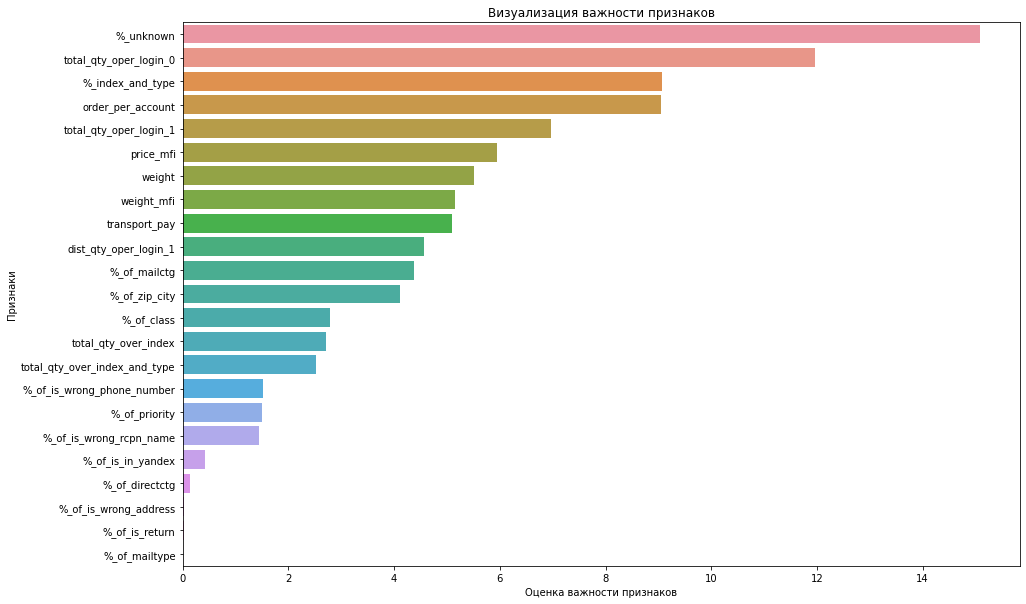

In [396]:
import seaborn as sns
import matplotlib.pyplot as plt
def chart_feature_imp(model):
    feature_imp = pd.Series(model.feature_importances_, index=X_train.columns).sort_values(ascending=False)
    plt.figure(figsize=(15, 10))
    ax = sns.barplot(x=feature_imp, y=feature_imp.index)
    _ = ax.set(xlabel='Оценка важности признаков', ylabel='Признаки')
    _ = ax.set_title('Визуализация важности признаков')
    print(feature_imp.head(50))#


![image.png](attachment:image.png)
chart_feature_imp(cat)

## Inference on the public test set

In [ ]:
df_test = pd.read_csv("test.csv")

# preprocessing pipeline identical to train
df_test.loc[df_test["index_oper"] == " ", "index_oper"] = 0
df_test["index_oper"] = (
    df_test["index_oper"].astype(float).astype(int).astype(str)
)

for col in cat_cols:
    df_test[col] = df_test[col].astype(str)

for col in columns_all:
    m = (
        df_copy.pivot_table(
            values=f"%_of_{col}", index=col, aggfunc="mean"
        )[f"%_of_{col}"]
        .to_dict()
    )
    df_test[f"%_of_{col}"] = df_test.apply(
        lambda r, c=col, mp=m: mp.get(r[c], 0), axis=1
    )

df_test["zip_city"] = df_test.apply(map_region, axis=1, lookup=my_dict)
df_test.fillna("unknown", inplace=True)

city_map = (
    df_copy.pivot_table(
        values="%_of_zip_city", index="zip_city", aggfunc="mean"
    )["%_of_zip_city"]
    .to_dict()
)
df_test["%_of_zip_city"] = df_test.apply(
    lambda r, mp=city_map: mp.get(r["zip_city"], 0), axis=1
)

df_test.drop(columns=del_col + ["zip_city"], inplace=True, errors="ignore")

df_test["%_index_and_type"] = (
    df_test["total_qty_over_index_and_type"] * 100
    / df_test["total_qty_over_index"]
)
df_test["%_unknown"] = (
    df_test["total_qty_oper_login_0"] * 100
    / df_test["total_qty_over_index_and_type"]
)
df_test["order_per_account"] = (
    df_test["total_qty_over_index_and_type"]
    / df_test["dist_qty_oper_login_1"]
)

for col_to_drop in [
    "%_of_type",
    "%_of_is_privatecategory",
    "%_of_is_wrong_sndr_name",
]:
    df_test.drop(columns=col_to_drop, errors="ignore", inplace=True)

df_test.fillna(0, inplace=True)
df_test.replace([np.inf, -np.inf], 0, inplace=True)


In [427]:
df_test.head(5)

,weight,transport_pay,weight_mfi,price_mfi,dist_qty_oper_login_1,total_qty_oper_login_1,total_qty_oper_login_0,total_qty_over_index_and_type,total_qty_over_index,%_of_priority,%_of_class,%_of_is_in_yandex,%_of_is_return,%_of_mailtype,%_of_mailctg,%_of_directctg,%_of_is_wrong_rcpn_name,%_of_is_wrong_phone_number,%_of_is_wrong_address,%_of_zip_city,%_index_and_type,%_unknown,order_per_account
0,85.0,0.00,73.0,489.0,972.0,68766046.0,91123247.0,159889293.0,164927295.0,2.850213,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.982038,1.828663,2.835738,3.498459,96.945319,56.991463,164495.157407
1,21.0,0.00,19.0,186.0,2.0,2895.0,1545.0,4440.0,20623.0,2.850213,10.276892,2.341582,2.848811,2.850904,8.193363,2.855003,2.466658,7.791488,2.835738,3.510569,21.529360,34.797297,2220.000000
2,388.0,34.01,348.0,500.0,3.0,2751.0,993.0,3744.0,37817.0,2.850213,10.276892,2.341582,2.848811,2.850904,1.423156,2.855003,2.982038,1.828663,2.835738,5.617566,9.900309,26.522436,1248.000000
3,1203.0,83.72,0.0,0.0,69.0,9379609.0,2267333.0,11646942.0,11759329.0,2.850213,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.466658,1.828663,2.835738,3.498459,99.044274,19.467196,168796.260870
4,956.0,14.95,946.0,1267.0,181.0,76138189.0,8747.0,76146936.0,84110459.0,2.847376,2.162049,3.190877,2.848811,2.850904,1.423156,2.855003,2.466658,1.828663,2.835738,3.498459,90.532066,0.011487,420701.303867


### Submission

In [ ]:
submit_proba = cat.predict_proba(df_test)[:, 1]
submit_label = (submit_proba > VAL_THRESHOLD).astype(int)

submission = pd.read_csv("sample_solution.csv")
submission["label"] = submit_label
submission.to_csv("submission.csv", index=False)

submission["label"].value_counts()

0    3279801
1     720199
Name: label, dtype: int64